# Taxi demand forescast
The RMSE metric on the test set should not be more than 48.

## 1. Preparation
In this section we will load and preprocess the data.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
#load data
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

#sort date as ascending
df_sorted = df.sort_index()

#get familiarized with the data
display(df_sorted.head())
print('='*70)
print()
df_sorted.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# check for missing values
df_sorted.isna().sum()

num_orders    0
dtype: int64

In [4]:
print('Is the data monotonic?\n',df_sorted.index.is_monotonic)

Is the data monotonic?
 True


In [5]:
#resample data for hourly sum
df_resampled = df_sorted.resample('1H').sum()

#check the resulted table
df_resampled.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


### 1.1 Conclusion
Data and required Python libraries have been successfully loaded. Original data has **26496 entries**, which is showing a number of taxi orders every 10 minutes. No missing values and other errors observed so far. Data has been resampled to get the total taxi order per hour instead of every 10 minutes.

## 2. Analysis
We will conduct EDA in this section in order to better understand the data.

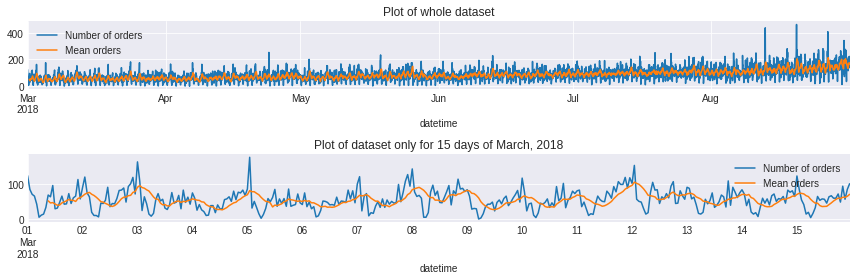

In [6]:
#plot a linechart for the whole data
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12,4))
plt.subplot(211)
df_resampled['num_orders'].plot(ax=plt.gca(), label='x')
df_resampled['num_orders'].rolling(10).mean().plot(ax=plt.gca())
plt.title('Plot of whole dataset')
plt.legend(['Number of orders','Mean orders'])

#plot a line chart for only 15 days of data
plt.subplot(212)
df_resampled['num_orders'][:360].plot(ax=plt.gca())
df_resampled['num_orders'][:360].rolling(10).mean().plot(ax=plt.gca())
plt.title('Plot of dataset only for 15 days of March, 2018')
plt.legend(['Number of orders','Mean orders'])
plt.tight_layout()
plt.show()

From the first chart, we can not get much information, but what we can see is that the number of orders gets higher near to the end compared to the beginning. When we look at the two charts together, we can see that there is a small peak every day near midnight (24:00) and at the weekends (5th and 12 of March). we will inspect these observations further.

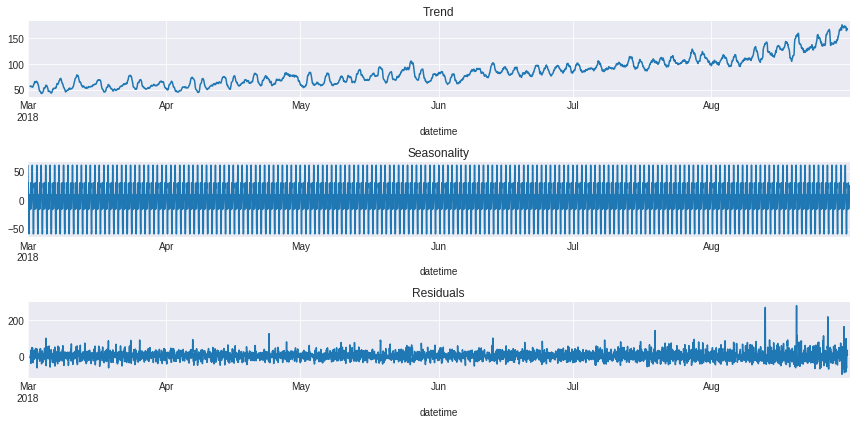

In [7]:
#check for trend and seasonality
decomposed = seasonal_decompose(df_resampled['num_orders'])
plt.figure(figsize=(12, 6))

#plot a chart for trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

#plot a chart for seasonality
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

#plot a chart for residuals 
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

As we have already hypothesized, there is a trend in our overall data. The number of orders getting higher and higher. But seasonality chart is not so informative in its current form. Let's get a narrower range and try to understand it.

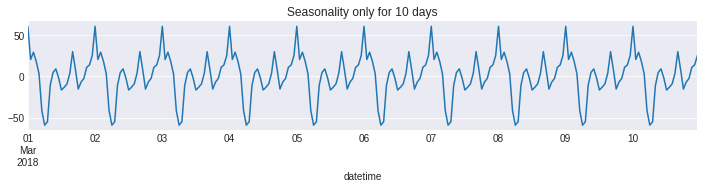

In [8]:
#seasonality chart for only 10 days
decomposed.seasonal[:240].plot(figsize=(12,2))
plt.title('Seasonality only for 10 days')
plt.show()

Now we can clearly see that every day at midnight, taxi orders peaking and near to morning orders dipping. But let's build another visualizations, which are showing average hourly, daily and monthly orders. 

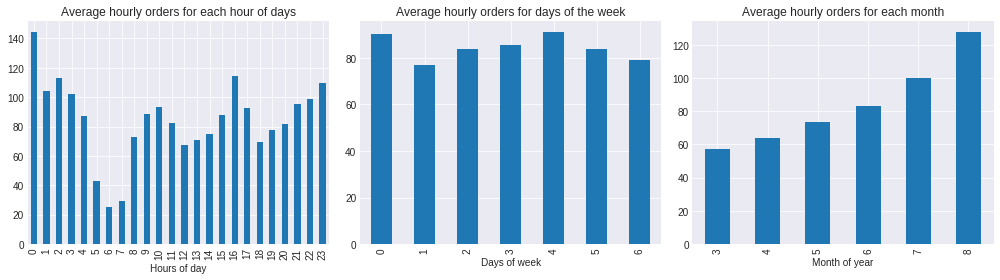

In [9]:
#group the data by hours of days, and get average orders at each hour of day
plt.figure(figsize=(14, 4))
plt.subplot(131)
df_resampled.groupby(df_resampled.index.hour)['num_orders'].mean().plot(kind='bar', ax=plt.gca())
plt.title('Average hourly orders for each hour of days')
plt.xlabel('Hours of day')


#group the data by days of week and get average orders at each day
plt.subplot(132)
df_resampled.groupby(df_resampled.index.dayofweek)['num_orders'].mean().plot(kind='bar', ax=plt.gca())
plt.title('Average hourly orders for days of the week')
plt.xlabel('Days of week')

#group the data by months and get average for each month
plt.subplot(133)
df_resampled.groupby(df_resampled.index.month)['num_orders'].mean().plot(kind='bar', ax=plt.gca())
plt.title('Average hourly orders for each month')
plt.xlabel('Month of year')


plt.tight_layout()
plt.show()

As we already observed, once more we have witnessed that taxi orders are peaking at around 01:00 and it is dipping about 06:00. There is no clear difference between average orders of days of a week. However, the monthly trend is very clear, that the average number of orders in March is around 60, but it gradually increased and ultimately in August it reached 130 orders (more than two times.)

### 2.1 Conclusion
It has been observed that data has both trend and seasonality. The trend is that the number of taxi orders gradually increasing from the beginning of data to the end (in March average hourly order is 60 vs in August average hourly order is 130). Seasonality is daily, which means everyday midnight taxi orders get a peak, and near to morning hours (6 am), it gets a dip.

## 3. Training
In this section we will check different algorithms with tuning hyperparameters, if any. Following algorithms will be check.
- LinearRegression
- RandomForest
- LightGBM

Before that, let's prepare our features. We have observed that the month and hour of the day have a great impact on the number of orders. Therefore, we will create month and hour columns. Then we have seen that there is daily seasonality, hence we will choose lag for 24 hours. And setting rolling mean values to 24 will again give use more stationary mean, std.

In [10]:
#a function to build extra columns:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    #df['day'] = df.index.day
    #df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
#apply the function with 10 lags and rolling mean of last 10 rows
make_features(df_resampled, max_lag = 24, rolling_mean_size = 24)
df_resampled.head(2)

,num_orders,month,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#prepare training and testing datasets
train, test = train_test_split(df_resampled, shuffle=False, test_size=0.1, random_state=234)
train = train.dropna()

#preapre features and target columns
X_train = train.drop("num_orders", axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

#proportion of training dataset that should be used for validation during hyperparameter tuning
val_offset = int(len(X_train)*0.9)

print(f'Traing features {X_train.shape} and testing features {X_test.shape}.')
print(f'Traing target   {y_train.shape} and testing target      {y_test.shape}.')
print(f'{len(X_train) - val_offset} rows of trianing set will be used for validation purposes during hp tuning.')

Traing features (3950, 27) and testing features (442, 27).
Traing target   (3950,) and testing target      (442,).
395 rows of trianing set will be used for validation purposes during hp tuning.


### 3.1 LinearRegression
Linear regression does not have hyperparameteres. So we will just train it and test it with testing set.

In [13]:
start = time.time()
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

cur_time = time.time()
lr_fit_time = cur_time-start
lr_y_pred = lin_model.predict(X_test)

cur_time2 = time.time()
lr_pred_time = cur_time2 - cur_time 
lr_rmse = mean_squared_error(y_test, lr_y_pred)**0.5
print(f'RMSE score of the LinearRegression model with testing set is {lr_rmse:.4}')
print(f'Fitting time of LinearRegression is {lr_fit_time:.2} sec and prediction time is {lr_pred_time:.2} sec.')

RMSE score of the LinearRegression model with testing set is 45.73
Fitting time of LinearRegression is 0.0071 sec and prediction time is 0.086 sec.


### 3.2 RandomForest

For the RandomForest, the number of trees (n_estimators) and size of the tree (max_depth) have paramount importance. Hence, we will tune these parameters and then use optimal parameters to test the model with the testing set (Note, during hyperparameter tuning we will use a 10% portion of the training set for validation purposes).

In [23]:
# tune the n_estimators
for i in [10, 50, 100, 150]:
    rf_model = RandomForestRegressor(n_estimators=i, random_state=234)
    rf_model.fit(X_train[:val_offset], y_train[:val_offset])    #here I am taking initial 90% rows for training
    rf_y_pred = rf_model.predict(X_train[val_offset:])      #rest 10% will be used for validation purposes
    rmse = mean_squared_error(y_train[val_offset:], rf_y_pred)**0.5    
    print(f'RMSE of the RandomForest model with {i} estimators is {rmse:.3}.')
    print("*"*50)

RMSE of the RandomForest model with 10 estimators is 33.2.
**************************************************
RMSE of the RandomForest model with 50 estimators is 32.2.
**************************************************
RMSE of the RandomForest model with 100 estimators is 31.9.
**************************************************
RMSE of the RandomForest model with 150 estimators is 31.7.
**************************************************


In [15]:
#tune the max_depth
for i in [3, 5, 10, 15]:
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=i, random_state=234)
    rf_model.fit(X_train[:val_offset], y_train[:val_offset])
    rf_y_pred = rf_model.predict(X_train[val_offset:])
    rmse = mean_squared_error(y_train[val_offset:], rf_y_pred)**0.5    
    print(f'RMSE of the RandomForest model with 50 estimators and {i} max_depth is {rmse:.3}.')
    print()

RMSE of the RandomForest model with 50 estimators and 3 max_depth is 41.9.

RMSE of the RandomForest model with 50 estimators and 5 max_depth is 36.8.

RMSE of the RandomForest model with 50 estimators and 10 max_depth is 32.4.

RMSE of the RandomForest model with 50 estimators and 15 max_depth is 31.9.



In [16]:
#use optimal n_estimators and max_depth to test best model
start = time.time()
best_rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=234)
best_rf_model.fit(X_train, y_train)

cur_time = time.time()
rf_fit_time = cur_time-start

rf_y_pred = best_rf_model.predict(X_test)

cur_time2 = time.time()
rf_pred_time = cur_time2 - cur_time

rf_rmse = mean_squared_error(y_test, rf_y_pred)**0.5
print(f'RMSE score of the RandomForest model with testing set is {rf_rmse:.3}')
print(f'Fitting time of RandomForest is {rf_fit_time:.2} sec and prediction time is {rf_pred_time:.2} sec.')

RMSE score of the RandomForest model with testing set is 43.0
Fitting time of RandomForest is 6.0 sec and prediction time is 0.019 sec.


### 3.3 LightGBM
For LightGBM the number of estimators and the maximum leaves are hyperparameters. Therefore a similar manner to RandomForest, we will tune LightGBM. Then use the optimal parameters for testing.

In [17]:
#tune n_estimators and max_leaves
n_estimators = [10, 50, 50]
max_leaves = [2, 4, 6]
for n, m in zip(n_estimators, max_leaves):
    lg_model = LGBMRegressor(n_estimators=n, max_leaves=m, learning_rate=1.0, random_state=234)
    lg_model.fit(X_train[:val_offset], y_train[:val_offset])
    lg_y_pred = lg_model.predict(X_train[val_offset:])
    rmse = mean_squared_error(y_train[val_offset:], lg_y_pred)**0.5
    print(f'RMSE score for LightGBM model with {n} estimators and {m} maximum leaves is {rmse:.4}.')
    print()

RMSE score for LightGBM model with 10 estimators and 2 maximum leaves is 37.91.

RMSE score for LightGBM model with 50 estimators and 4 maximum leaves is 40.66.

RMSE score for LightGBM model with 50 estimators and 6 maximum leaves is 40.66.



In [18]:
#use optimal n_estimators and max_leaves to test best model
start = time.time()
best_lg_model = LGBMRegressor(n_estimators=50, max_leaves=4, random_state=234)
best_lg_model.fit(X_train, y_train)
cur_time = time.time()
lg_fit_time = cur_time-start

lg_y_pred = best_lg_model.predict(X_test)
cur_time2 = time.time()
lg_pred_time = cur_time2 - cur_time 
lg_rmse = mean_squared_error(y_test, lg_y_pred)**0.5
print(f'RMSE score of the LigthGBM model is {lg_rmse:.3}')
print(f'Fitting time of LightGBM is {lg_fit_time:.2} sec and prediction time is {lg_pred_time:.2} sec.')

RMSE score of the LigthGBM model is 43.3
Fitting time of LightGBM is 1.1 sec and prediction time is 0.099 sec.


### Conclusion
We have tested three different models (whenever applicable after tuning the hyperparameters). Results are as following:

|Algorithm            |RMSE score|Training time |Prediction time|
|---------------------|----------|------------- |---------------|
|LinearRegression     |45.7      |0.078         |0.076          |
|RandomForestRegressor|43.0      |6.1           |0.018          |
|LightGBMRegressor    |43.3      |11.0           |0.096         |

## 4. Testing
To test sanity of model, we will develop two constant models and evaluate their RMSE. Then we will benchmark our previous models with these constant models.

### 4.1 Constant model - median

We will use median value of training set as target of testing set.

In [19]:
# create target of test using median value of training set.
cm1_y_pred = np.ones(y_test.shape) * y_train.median()
cm1_rmse = mean_squared_error(y_test, cm1_y_pred)**0.5
print(f'RMSE of constant model which uses median of training sets as future prediction is {cm1_rmse:.3}.')

RMSE of constant model which uses median of training sets as future prediction is 87.2.


### 4.2 Constant model - last value

In [20]:
# create target of test using last observed value as a target.
cm2_y_pred = y_test.shift()
cm2_y_pred.iloc[0] = y_train.iloc[-1]
cm2_rmse = mean_squared_error(y_test, cm2_y_pred)**0.5
print(f'RMSE of constant model which uses median of training sets as future prediction is {cm2_rmse:.3}.')

RMSE of constant model which uses median of training sets as future prediction is 58.9.


### 4.3 Benchmarking

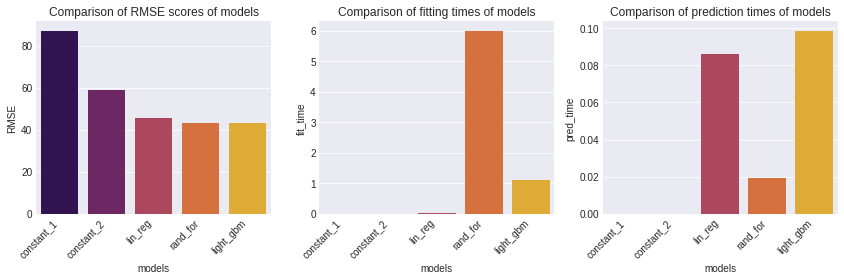

In [21]:
#create a dataframe containg results of all above models
bench = pd.DataFrame({'models':['constant_1', 'constant_2', 'lin_reg', 'rand_for','light_gbm'],
                      'RMSE':[cm1_rmse, cm2_rmse, lr_rmse, rf_rmse, lg_rmse],
                     'fit_time':[0, 0, lr_fit_time, rf_fit_time, lg_fit_time],
                     'pred_time':[0, 0, lr_pred_time, rf_pred_time, lg_pred_time]})

#plot barplots comparing rmse score, fitting time and prediciton time of models
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.barplot(data=bench, x='models', y='RMSE', ax=ax[0], palette='inferno')
ax[0].set_title('Comparison of RMSE scores of models')
ax[0].set_xticklabels(bench['models'], rotation = 45, ha="right")

sns.barplot(data=bench, x='models', y='fit_time', ax=ax[1], palette='inferno')
ax[1].set_title('Comparison of fitting times of models')
ax[1].set_xticklabels(bench['models'], rotation = 45, ha="right")

sns.barplot(data=bench, x='models', y='pred_time', ax=ax[2], palette='inferno')
ax[2].set_title('Comparison of prediction times of models')
ax[2].set_xticklabels(bench['models'], rotation = 45, ha="right")

plt.tight_layout()
plt.show()

From the above plots, we can see that RMSE scores of LinearReg, RandForest, and LigthGBM models do not differ significantly. All of them are fairly better than constant models. However, if we compare the training and prediction times required for each model, we can see that the fitting of time LinearReg model is way better than RandForest and LightGBM. But when it comes to predicting, LightGBM is the best, although LinearReg and RandForest also did well, predicting in less than 1 second.

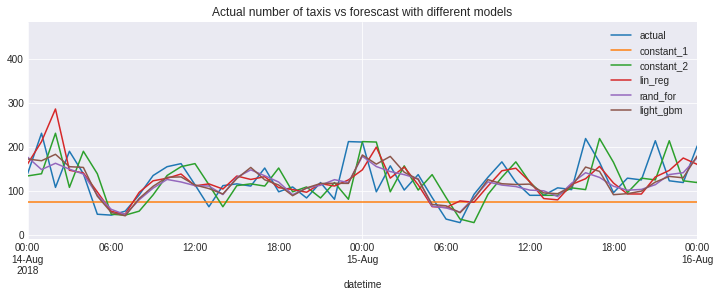

In [22]:
# compare actual and predicted values of target for two days
targets = pd.DataFrame({'actual':y_test,'constant_1': cm1_y_pred, 'constant_2':cm2_y_pred, 
                        'lin_reg': lr_y_pred, 'rand_for':rf_y_pred,'light_gbm':lg_y_pred})
targets.plot(figsize=(12, 4))
plt.xlim('2018-08-14', '2018-08-16')
plt.title('Actual number of taxis vs forescast with different models')
plt.show()

As we can see from the above line chart, constant model 1, which uses the median value of the training set as a forecast, has a straight line. On another hand, constant model 2, which uses the last value as a forecast, has a shift of peaks or dips in the graph. However, the other models were a little bit pessimistic, i.e. when there is a peak, models never exceeded that peak.

### 4.4 Conclusion
Two constant models were built, where one uses median values of the training set as the predicted value, while another uses the last observed value as a prediction. These two constant models achieved RMSE scores of 87.2 and 58.9, respectively. Compared to these constant models, our all models (LinearRegerssion, RandomForest, and LightGBM) achieved much better (RMSE 45.7, 43.0, and 43.3, respectively). However, among these three models, RandomForest achieved the best RMSE score. But its fitting and prediction times are much worse than LinaerRegerssion. 

As a summary, we can say that the LinearRegerssion model, achieved a fairly good prediction of required taxis with $\pm$ 45.7 within less than a second. 

## 5. Summary

- Data with **26496 entries**, which is showing a number of taxi orders for every 10 minutes, has been loaded. It has been **resampled to get the total taxi order per hour instead of every 10 minutes.**

- It has been observed that **data has both trend and seasonality**. The trend is that the number of taxi orders gradually increasing from the beginning of data to the end (**in March average hourly order is 60 vs in August average hourly order is 130**). Seasonality is daily, which means **everyday midnight taxi orders get a peak, and near to morning hours (6 am), it gets a dip.**

- We have tested three different models (whenever applicable after tuning the hyperparameters). Results are as following:

|Algorithm            |RMSE score|Training time |Prediction time|
|---------------------|----------|------------- |---------------|
|LinearRegression     |45.7      |0.028         |0.0016         |
|RandomForestRegressor|43.0      |6.1           |0.018          |
|LightGBMRegressor    |43.3      |1.0           |0.0096         |

- Two constant models were built, where one uses median values of the training set as the predicted value, while another uses the last observed value as a prediction. These two constant models achieved RMSE scores of 87.2 and 58.9, respectively. Compared to these constant models, our all models (LinearRegerssion, RandomForest, and LightGBM) achieved much better (RMSE 45.7, 43.0, and 43.3, respectively).

> **As a summary, we can say that the LinearRegerssion model, achieved a fairly good prediction of required taxis with $\pm$ 45.7 within less than a second.**